In [1]:
#imports
import numpy as np
import pandas as pd 
import pydicom
import os
import sys
import scipy.ndimage
import matplotlib.pyplot as plt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

In [2]:
#path constants
ROOT_DIR = '../'
DATA_DIR = 'data/train_images/'
DEST_DIR = 'preprocessing/raw_data/'

In [5]:
#patient directories
studies = os.listdir(os.path.join(ROOT_DIR, DATA_DIR))
studies.sort()

#metadata dataframe
metadata_df = pd.DataFrame(columns=['study_id',
                                    'series_id',
                                    'orientation',
                                    'dim_x',
                                    'dim_y',
                                    'pixel_dim_x',
                                    'pixel_dim_y',
                                    'rows',
                                    'columns',
                                    'num_slices',
                                    'slice_spacing',
                                    'slice_thickness',
                                    'series_description',
                                    'patient_position',
                                    'image_position',
                                    'image_orientation',
                                    'photometric_interpretation',
                                    'pixel_representation'
                                    'scan_dim_x_mm',
                                    'scan_dim_y_mm',
                                    'scan_dim_z_mm'])

per_slice_metadata_columns = [
    'ContentDate',
    'ContentTime',
    'SliceThickness',
    'SpacingBetweenSlices',
    'SliceLocation',
    'InstanceNumber',
    'ImagePositionPatient',
    'ImageOrientationPatient',
    'PixelSpacing',
    'WindowCenter',
    'WindowWidth'
]

study_metadata_columns = [
    'is_valid',
    'num_Axial_T2',
    'num_Sagittal_T2-STIR',
    'num_Sagittal_T1',
    'Spinal-Canal-Stenosis-L1/L2',
    'Spinal-Canal-Stenosis-L2/L3',
    'Spinal-Canal-Stenosis-L3/L4',
    'Spinal-Canal-Stenosis-L4/L5',
    'Spinal-Canal-Stenosis-L5/S1',
    'Right-Neural-Foraminal Narrowing-L4/L5',
    'Right-Neural-Foraminal Narrowing-L5/S1',
    'Right-Neural-Foraminal Narrowing-L3/L4',
    'Right-Neural-Foraminal Narrowing-L1/L2',
    'Right-Neural-Foraminal Narrowing-L2/L3',
    'Left-Neural-Foraminal-Narrowing-L1/L2',
    'Left-Neural-Foraminal-Narrowing-L4/L5',
    'Left-Neural-Foraminal-Narrowing-L5/S1',
    'Left-Neural-Foraminal-Narrowing-L2/L3',
    'Left-Neural-Foraminal-Narrowing-L3/L4',
    'Left-Subarticular-Stenosis-L1/L2',
    'Right Subarticular-Stenosis-L1/L2',
    'Left Subarticular-Stenosis-L2/L3',
    'Right Subarticular-Stenosis-L2/L3',
    'Left Subarticular-Stenosis-L3/L4',
    'Right Subarticular-Stenosis-L3/L4',
    'Left Subarticular-Stenosis-L4/L5',
    'Right Subarticular-Stenosis-L4/L5',
    'Left Subarticular-Stenosis-L5/S1',
    'Right Subarticular-Stenosis-L5/S1'
]

In [6]:
def load_scan(path: str)-> tuple[np.ndarray, list, pd.DataFrame]:
    '''
    Extracts 3d pixel data, metadata, and per-slice metadata from scan directory
    \n Code partially taken and modified from 
    \n https://www.kaggle.com/code/gzuidhof/full-preprocessing-tutorial
    '''
    #Get slices from scan
    slices = [pydicom.read_file(path + '/' + s) for s in os.listdir(path)]
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    
    #Get scan metadata
    study_id                   = int(str(slices[0].SeriesInstanceUID).split('.')[0])
    series_id                  = int(str(slices[0].SeriesInstanceUID).split('.')[1])
    orientation                = "empty"
    dim_x                      = slices[0].pixel_array.shape[0]
    dim_y                      = slices[0].pixel_array.shape[1]
    pixel_dim_x                = float(slices[0].PixelSpacing[0])
    pixel_dim_y                = float(slices[0].PixelSpacing[1])
    rows                       = slices[0].Rows
    columns                    = slices[0].Columns
    num_slices                 = len(slices)
    slice_spacing              = float(slices[0].SpacingBetweenSlices)
    slice_thickness            = float(slices[0].SliceThickness)
    series_description         = slices[0].SeriesDescription
    patient_position           = slices[0].PatientPosition
    image_position             = slices[0].ImagePositionPatient
    image_orientation          = slices[0].ImageOrientationPatient
    photometric_interpretation = slices[0].PhotometricInterpretation
    scan_dim_x_mm              = dim_x * pixel_dim_x
    scan_dim_y_mm              = dim_y * pixel_dim_y
    scan_dim_z_mm              = num_slices * slice_spacing
    pixel_representation       = slices[0].PixelRepresentation
    
    #put metadata in list
    scan_metadata = [
        study_id,
        series_id,
        orientation,
        dim_x,
        dim_y,
        pixel_dim_x,
        pixel_dim_y,
        rows,
        columns,
        num_slices,
        slice_spacing,
        slice_thickness,
        series_description,
        patient_position,
        image_position,
        image_orientation,
        photometric_interpretation,
        scan_dim_x_mm,
        scan_dim_y_mm,
        scan_dim_z_mm,
        pixel_representation
    ]
    
    #Get per-slice metadata
    per_slice_metadata_df = pd.DataFrame(columns=per_slice_metadata_columns)
    for slice in slices:
        ContentDate = slice.ContentDate
        ContentTime = slice.ContentTime
        SliceThickness = slice.SliceThickness
        SpacingBetweenSlices = slice.SpacingBetweenSlices
        SliceLocation = slice.SliceLocation
        InstanceNumber = slice.InstanceNumber
        ImagePositionPatient = slice.ImagePositionPatient
        ImageOrientationPatient = slice.ImageOrientationPatient
        PixelSpacing = slice.PixelSpacing
        WindowCenter = slice.WindowCenter
        WindowWidth = slice.WindowWidth
        
        slice_metadata = [
            ContentDate,
            ContentTime,
            SliceThickness,
            SpacingBetweenSlices,
            SliceLocation,
            InstanceNumber,
            ImagePositionPatient,
            ImageOrientationPatient,
            PixelSpacing,
            WindowCenter,
            WindowWidth
        ]
        # pd.concat([per_slice_metadata_df, slice_metadata])
        per_slice_metadata_df.loc[len(per_slice_metadata_df)] = slice_metadata
        
        #make 3D
        image = np.stack([s.pixel_array for s in slices])
    
    return image, scan_metadata, per_slice_metadata_df

In [3]:
saved_metadata = pd.read_csv('../preprocessing/raw_data/dataset_metadata.csv')
saved_metadata.columns

Index(['Unnamed: 0', 'study_id', 'series_id', 'orientation', 'dim_x', 'dim_y',
       'pixel_dim_x', 'pixel_dim_y', 'rows', 'columns', 'num_slices',
       'slice_spacing', 'slice_thickness', 'series_description',
       'patient_position', 'image_position', 'image_orientation',
       'photometric_interpretation', 'scan_dim_x_mm', 'scan_dim_y_mm',
       'scan_dim_z_mm'],
      dtype='object')

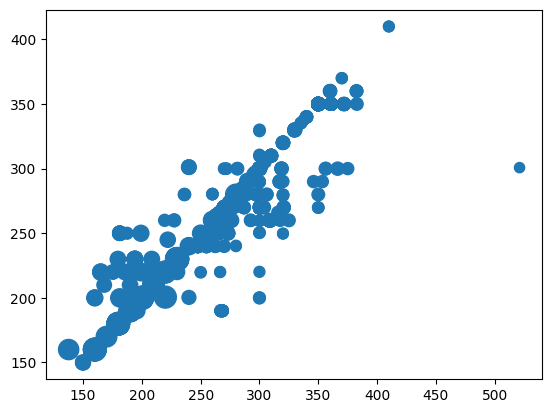

In [4]:
# saved_metadata['pixel_dim_x']
plt.scatter(saved_metadata['scan_dim_x_mm'], saved_metadata['scan_dim_y_mm'], saved_metadata['scan_dim_z_mm'])


In [7]:
def process_and_save_data(root_dir, data_dir, dest_dir):
    '''
    
    '''
    num_studies = 0
    num_scans = 0
    
    data_path = os.path.join(root_dir, data_dir)
    dest_path = os.path.join(root_dir, dest_dir)
    
    study_ids = os.listdir(data_path)
    
    for study in study_ids:
        study_path = os.path.join(data_path, study)
        series_ids = os.listdir(study_path)
        
        dest_study_path = os.path.join(dest_path, study)
        if not os.path.exists(dest_study_path):
            os.makedirs(dest_study_path)
        
        series_data = []
        #load individual scans
        for series in series_ids:
            try:
                image, metadata, per_slice_metadata = load_scan(os.path.join(study_path, series))
                
                save_path = os.path.join(dest_path, study, series)
                
                if not os.path.exists(save_path):
                    os.makedirs(save_path)
                    
                np.save(os.path.join(save_path, (series + '.npy')), image)
                per_slice_metadata.to_csv(os.path.join(save_path, (series + '_metadata.csv')))
                metadata_df.loc[len(metadata_df)] = metadata
                num_scans += 1
            except Exception as error:
                print(f'error thrown on study {study}, series {series} \n {error}')
        num_studies += 1
    metadata_df.to_csv(os.path.join(dest_path, 'dataset_metadata.csv'))
    print(f'loaded {num_studies} studies and {num_scans} scans')
    

In [8]:
process_and_save_data(ROOT_DIR, DATA_DIR, DEST_DIR)

error thrown on study 114899184, series 1364910156 
 all input arrays must have the same shape
error thrown on study 1258848546, series 178314290 
 all input arrays must have the same shape
error thrown on study 1271819130, series 396937199 
 all input arrays must have the same shape
error thrown on study 1537608176, series 2603019387 
 all input arrays must have the same shape
error thrown on study 1538136131, series 533252904 
 all input arrays must have the same shape
error thrown on study 1603568458, series 3451074679 
 all input arrays must have the same shape
error thrown on study 1973833645, series 1328374636 
 all input arrays must have the same shape
error thrown on study 1992037544, series 2051789894 
 all input arrays must have the same shape
error thrown on study 1995123254, series 1133656256 
 all input arrays must have the same shape
error thrown on study 2083466060, series 2440822236 
 all input arrays must have the same shape
error thrown on study 2334206006, series 419

In [9]:
def resample(image, scan, new_spacing=[1,1,1]):
    # Determine current pixel spacing
    spacing = np.array([scan[0].SpacingBetweenSlices] + list(scan[0].PixelSpacing), dtype=np.float32)

    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    
    image = scipy.ndimage.zoom(image, real_resize_factor, mode='nearest')
    
    return image, new_spacing

In [10]:
def plot_3d(image, threshold=-300):
    # Position the scan upright, 
    # so the head of the patient would be at the top facing the camera
    p = image.transpose(2,1,0)
    
    verts, faces, normals, values = measure.marching_cubes(p, threshold)

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')

    # Fancy indexing: `verts[faces]` to generate a collection of triangles
    mesh = Poly3DCollection(verts[faces], alpha=0.70)
    face_color = [0.45, 0.45, 0.75]
    mesh.set_facecolor(face_color)
    ax.add_collection3d(mesh)

    ax.set_xlim(0, p.shape[0])
    ax.set_ylim(0, p.shape[1])
    ax.set_zlim(0, p.shape[2])

    plt.show()

In [11]:
raw_data_dir = os.path.join(ROOT_DIR, DEST_DIR, '4282019580/1547999333/1547999333.npy')
scan_dir = os.path.join(ROOT_DIR, DATA_DIR, '4282019580/1547999333/')

image = np.load(raw_data_dir)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        for k in range(image.shape[2]):
            if image[i][j][k] < 0:
                image[i][j][k] = 0
scan = [pydicom.dcmread(os.path.join(scan_dir, dcm)) for dcm in os.listdir(scan_dir)]
resampled_image, new_spacing = resample(image, scan, [2,2,2])
print("Shape before resampling\t", image.shape)
print("Shape after resampling\t", resampled_image.shape)

C:\Users\hmhor\AppData\Local\Temp\ipykernel_6336\1212059043.py:11: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (21, 384, 384)
Shape after resampling	 (46, 130, 130)


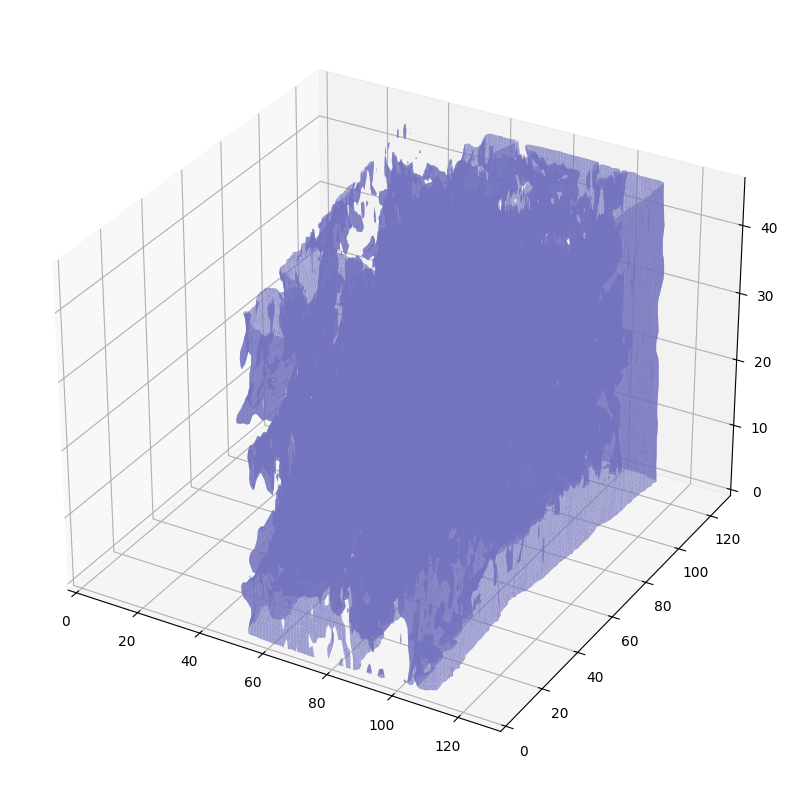

In [12]:
plot_3d(resampled_image, 100)
# resampled_image[0]

C:\Users\hmhor\AppData\Local\Temp\ipykernel_9180\3114917553.py:11: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  image = scipy.ndimage.interpolation.zoom(image, real_resize_factor, mode='nearest')


Shape before resampling	 (17, 384, 384)
Shape after resampling	 (68, 300, 300)


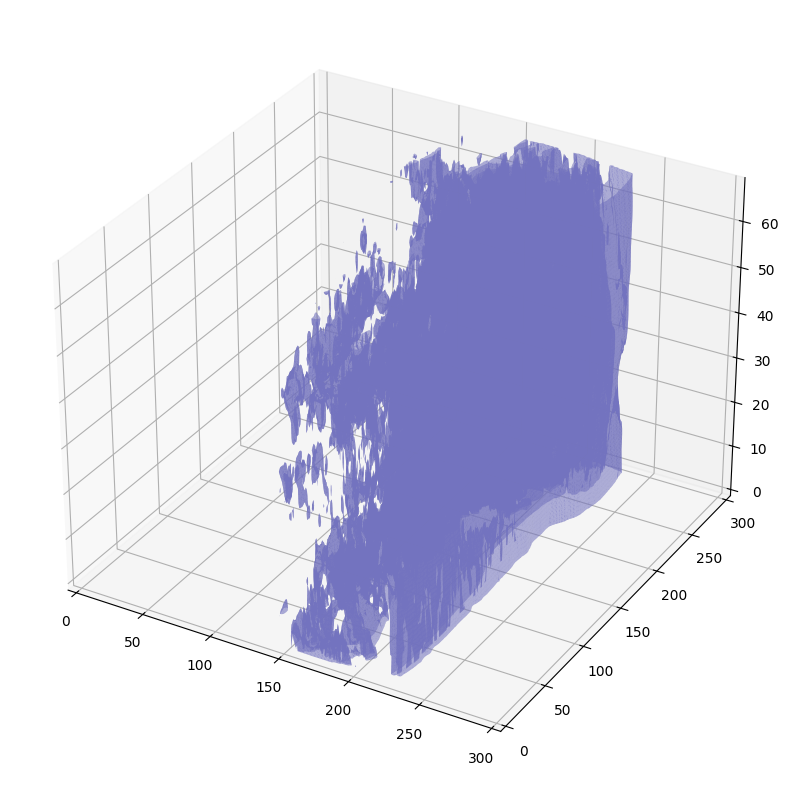

In [80]:

raw_data_dir = os.path.join(ROOT_DIR, DEST_DIR, '992674144/1814811290/1814811290.npy')
scan_dir = os.path.join(ROOT_DIR, DATA_DIR, '992674144/1814811290/')

image = np.load(raw_data_dir)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        for k in range(image.shape[2]):
            if image[i][j][k] < 75:
                image[i][j][k] = 0
scan = [pydicom.dcmread(os.path.join(scan_dir, dcm)) for dcm in os.listdir(scan_dir)]
resampled_image, new_spacing = resample(image, scan, [1,1,1])
print("Shape before resampling\t", image.shape)
print("Shape after resampling\t", resampled_image.shape)
plot_3d(resampled_image, 300)

In [5]:
# print(saved_metadata['orientation'].str.count("sagittal").sum())
# print(saved_metadata['orientation'].str.count("indeterminate").sum())
# print(saved_metadata['orientation'].str.count("axial").sum())
saved_metadata['series_description'].unique()
# print(saved_metadata.iloc[6255])
print(saved_metadata['series_description'])
print("---T1---")
print(saved_metadata['study_id'].iloc[6257])
print(saved_metadata['series_id'].iloc[6257])
print("---T2---")
print(saved_metadata['study_id'].iloc[0])
print(saved_metadata['series_id'].iloc[0])
print("---T2---")
print(saved_metadata.iloc[0])

NameError: name 'saved_metadata' is not defined

        study_id   series_id series_description
5997  4096820034   300517765           Axial T2
5998  4096820034  2097107888           Axial T2
5999  4096820034  2602265508   Sagittal T2/STIR
6000  4096820034  2679683906           Axial T2
6001  4096820034  3114813181           Axial T2
6002  4096820034  3236751045        Sagittal T1
2
6
3.1868354430379746
3.0
0.43414178434630524
duplicate counts
2       3
3    1632
4     309
5      30
6       1
Name: study_id, dtype: int64


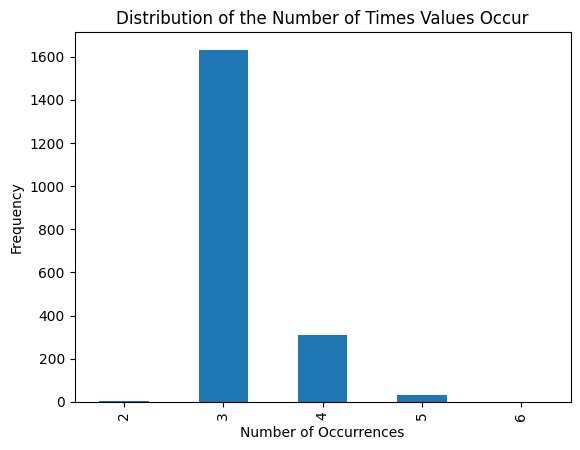

In [6]:
path = '../data/train_series_descriptions.csv'

train_series_description = pd.read_csv(path)
print(train_series_description.loc[train_series_description['study_id'] == 4096820034])
val_counts = train_series_description['study_id'].value_counts()

print(val_counts.min())
print(val_counts.max())
print(val_counts.mean())
print(val_counts.median())
print(val_counts.std())
print('duplicate counts')

frequency_of_frequencies = val_counts.value_counts().sort_index()
print(frequency_of_frequencies)

# Plot the distribution of the number of times values occur
frequency_of_frequencies.plot(kind='bar')
plt.xlabel('Number of Occurrences')
plt.ylabel('Frequency')
plt.title('Distribution of the Number of Times Values Occur')
plt.show()

In [11]:
train_label_coordinates = pd.read_csv('../data/train_label_coordinates.csv')

series_counts = train_label_coordinates["study_id"].value_counts().value_counts()

series_counts

25    1789
23      57
21      47
19      38
22      30
24      10
15       2
17       1
Name: study_id, dtype: int64

In [4]:
metadata = pd.read_csv('../preprocessing/raw_data/dataset_metadata.csv')
series_types = pd.read_csv('../data/train_series_descriptions.csv')

unified_axial_dimensions_list = []
i = 0
for series in series_types['series_id']:
    try:
        #get the type of scan this series is
        series_type = series_types.loc[series_types['series_id'] == series]
        # print(series_type['series_description'].item())
        
        series_t = str(series_type['series_description'].item())
        
        #get the metadata row for the dimensions
        metadata_row_idx = metadata['series_id'] == series
        
        # print(metadata.loc[metadata_row_idx, 'series_id'].item())
        
        # print(metadata.loc[metadata_row_idx, 'scan_dim_x_mm'].item(), '\n')
        
        if series_t == 'Sagittal T1' or series_t == 'Sagittal T2/STIR':
            unified_axial_dimensions_list.append([metadata.loc[metadata_row_idx, 'scan_dim_x_mm'].item(), 
                                                  metadata.loc[metadata_row_idx, 'scan_dim_z_mm'].item(), 
                                                  metadata.loc[metadata_row_idx, 'scan_dim_y_mm'].item()])
        else:
            unified_axial_dimensions_list.append([metadata.loc[metadata_row_idx, 'scan_dim_x_mm'].item(), 
                                                  metadata.loc[metadata_row_idx, 'scan_dim_y_mm'].item(), 
                                                  metadata.loc[metadata_row_idx, 'scan_dim_z_mm'].item()])
    except:
        i += 1
        print(f'{i} skipped')

unified_axial_dimensions = pd.DataFrame(unified_axial_dimensions_list,columns=['x_dim', 'y_dim', 'z_dim'])


1 skipped
2 skipped
3 skipped
4 skipped
5 skipped
6 skipped
7 skipped
8 skipped
9 skipped
10 skipped
11 skipped
12 skipped
13 skipped
14 skipped
15 skipped
16 skipped
17 skipped
18 skipped
19 skipped
20 skipped
21 skipped
22 skipped
23 skipped
24 skipped
25 skipped
26 skipped
27 skipped
28 skipped
29 skipped
30 skipped
31 skipped
32 skipped
33 skipped
34 skipped
35 skipped


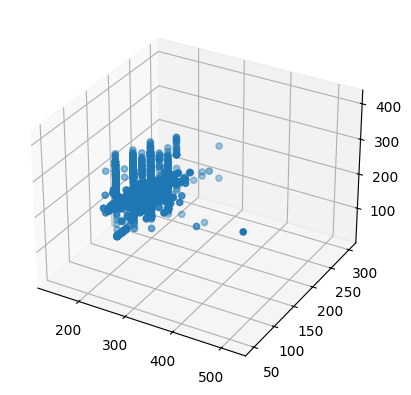

x median: 260.0
y median: 82.8
z median: 259.99999618530114 

x mean: 252.75334106209837
y mean: 118.35132426790746
z mean: 234.39648694667602 

x std: 54.90676618968038
y std: 57.37658852947988
z std: 76.80286973114683 

x min: 137.77788800000002
y min: 48.0
z min: 25.0 

x max: 521.09375
y max: 301.1584
z max: 410.0096 



In [5]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(unified_axial_dimensions['x_dim'], unified_axial_dimensions['y_dim'], unified_axial_dimensions['z_dim'])
plt.show()
# plt.scatter(unified_axial_dimensions['x_dim'], unified_axial_dimensions['y_dim'], unified_axial_dimensions['z_dim'],c='r', marker='o')
print('x median:',unified_axial_dimensions['x_dim'].median())
print('y median:',unified_axial_dimensions['y_dim'].median())
print('z median:',unified_axial_dimensions['z_dim'].median(),'\n')

print('x mean:',unified_axial_dimensions['x_dim'].mean())
print('y mean:',unified_axial_dimensions['y_dim'].mean())
print('z mean:',unified_axial_dimensions['z_dim'].mean(),'\n')

print('x std:',unified_axial_dimensions['x_dim'].std())
print('y std:',unified_axial_dimensions['y_dim'].std())
print('z std:',unified_axial_dimensions['z_dim'].std(),'\n')

print('x min:',unified_axial_dimensions['x_dim'].min())
print('y min:',unified_axial_dimensions['y_dim'].min())
print('z min:',unified_axial_dimensions['z_dim'].min(),'\n')

print('x max:',unified_axial_dimensions['x_dim'].max())
print('y max:',unified_axial_dimensions['y_dim'].max())
print('z max:',unified_axial_dimensions['z_dim'].max(),'\n')


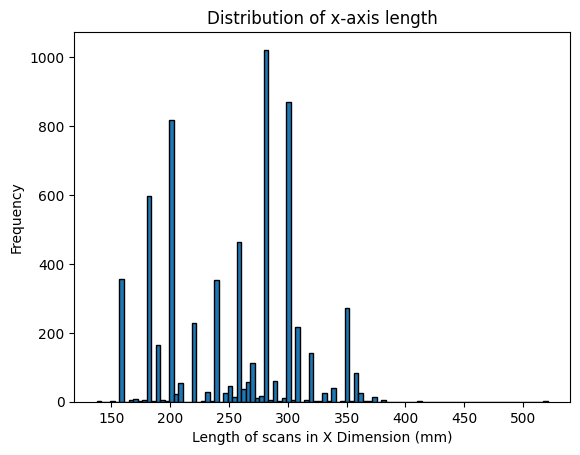

In [8]:
plt.hist(unified_axial_dimensions['x_dim'], bins=100, edgecolor='black')
plt.xlabel('Length of scans in X Dimension (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of x-axis length')
plt.show()


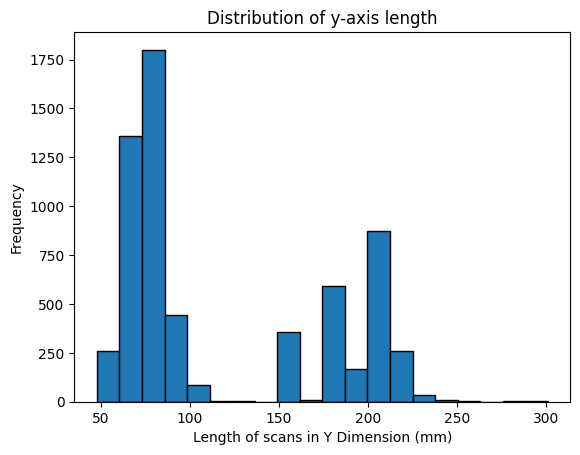

In [72]:
plt.hist(unified_axial_dimensions['y_dim'], bins=20, edgecolor='black')
plt.xlabel('Length of scans in Y Dimension (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of y-axis length')
plt.show()


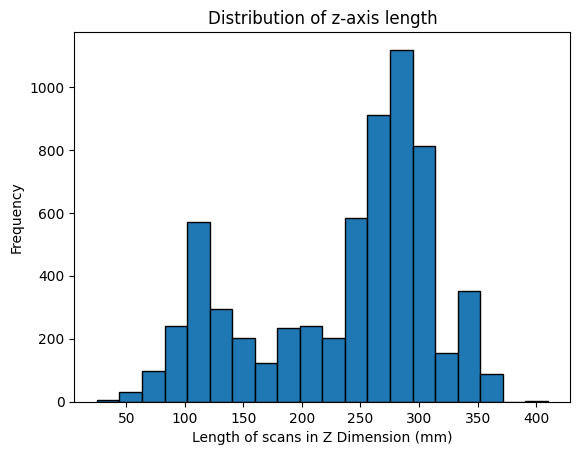

In [73]:
plt.hist(unified_axial_dimensions['z_dim'], bins=20, edgecolor='black')
plt.xlabel('Length of scans in Z Dimension (mm)')
plt.ylabel('Frequency')
plt.title('Distribution of z-axis length')
plt.show()


In [1]:
import os
from preprocessing_util import load_coord_data

path = '../data/train_label_coordinates.csv'

series = '3753885158'

coords = load_coord_data(path, series)
print(coords)

Empty DataFrame
Columns: [study_id, series_id, instance_number, condition, level, x, y]
Index: []
